In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import arfit.ar1_kalman as ar1
import astropy.io.fits as af
import emcee
import h5py
import plotutils.plotutils as pu
import plotutils.runner as pr
import scipy.signal as ss
import triangle

Populating the interactive namespace from numpy and matplotlib


Load the data from the HDF5 file.

In [2]:
with h5py.File('gran5wfill.hdf5', 'r') as inp:
    data = column_stack((inp['time'][:], inp['samples'][:]))

The Welch periodigram shows a definite AR(1) decay:

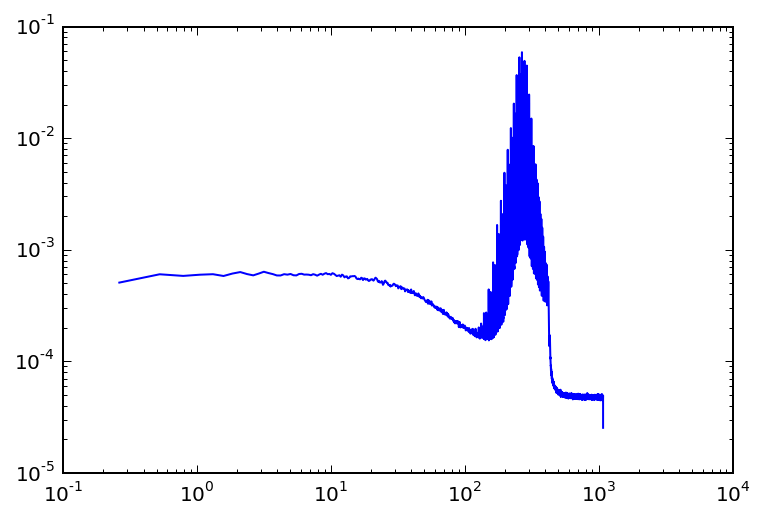

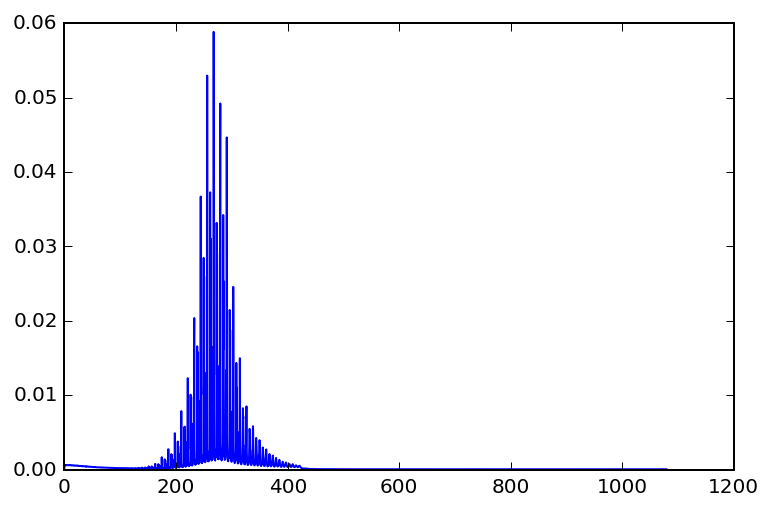

In [32]:
fs, psd = ss.welch(data[:,1], 1.0/(data[1,0]-data[0,0]), nperseg=8192)
loglog(fs, psd)
figure()
plot(fs, psd)

We want to be sure to dig well into the flat region (which shows up very clearly in 32K sample segments), so let's grab 100,000 samples.

In [8]:
trend_data = data[:100000, :]

Here are some properties:

* ``s2`` is the variance

* ``T`` is the total time

* ``dt`` is the timestep

* ``bw`` is the approximate bandwidth

* ``wn_sigma`` is an estimate of the standard deviation due to white noise, which appears with   a ``3e-5`` floor in the PSD.

In [9]:
s2 = var(trend_data[:,1])
T = trend_data[-1,0] - trend_data[0,0]
dt = trend_data[1,0]-trend_data[0,0]
bw = 1.0/(2*dt) - 1.0/T
wn_sigma = sqrt(3e-5*bw)
wn_sigma, sqrt(s2)

(0.17999814498719008, 0.80599101588536159)

Create a posterior object and associated sampler (with 2 threads).

In [47]:
logpost = ar1.AR1KalmanPosterior(trend_data[:,0], trend_data[:,1], wn_sigma + 0*trend_data[:,1])
sampler = emcee.EnsembleSampler(128, logpost.nparams, logpost, threads=2)

Run the sampler to get 128 independent samples out of each walker (so 128 * 128 = 16K samples in total).

In [48]:
runner = pr.EnsembleSamplerRunner(sampler, randn(128, logpost.nparams))
runner.load_state('.')
runner.run_to_neff(128, savedir='.')

KeyboardInterrupt: 

Just in case we terminated the run early, just load up the saved state:

In [39]:
runner.load_state('.')

The log-posterior for each of the walkers:

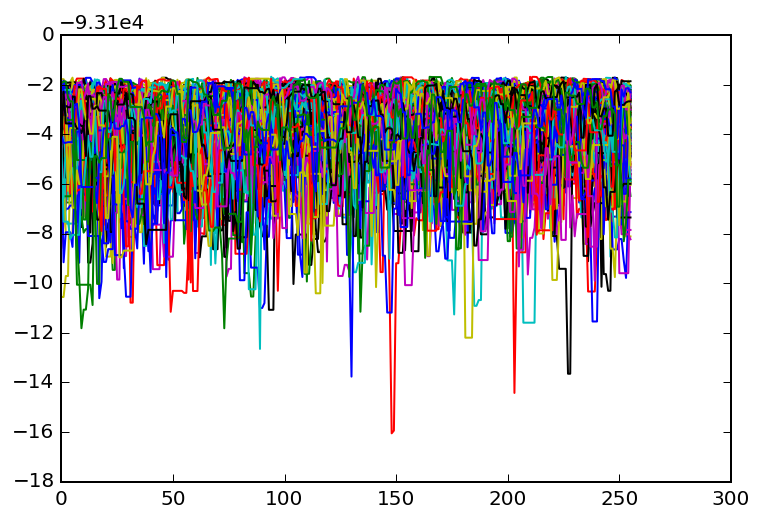

In [40]:
plot(runner.sampler.lnprobability.T); None

The mean of the ensemble in each parameter, standardised to mean=0, sigma=1, over time:

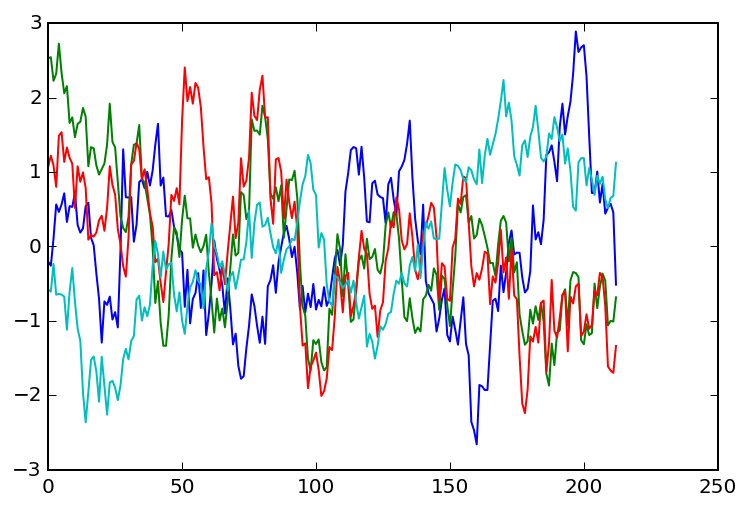

In [41]:
pu.plot_emcee_chains_one_fig(runner.burnedin_chain)

Full-on chain plot:

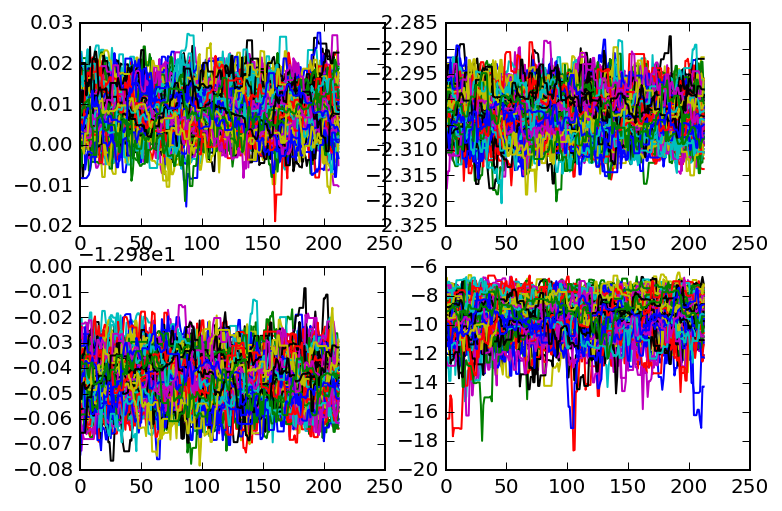

In [42]:
pu.plot_emcee_chains(runner.burnedin_chain, mean=False)

Extract the physical parameters from the burned-in chain, and plot, showing the median, 1-sigma, and 2-sigma credible intervals.  The meaning of the parmeters is the following:

* $\mu$ is the mean of the time series.

* $\sigma$ is the standard deviation at zero-lag (i.e. $\sqrt{\rho(0)}$).

* $\tau$ is the timescale for the exponential decay of correlations: $\rho(t) = \sigma^2 \exp(-t/\tau)$.

* $\nu$ is the scale factor on the white-noise errorbars.  $\nu \in [0.1, 10]$, and here the WN level is not measurable, so $\nu$ concentrates near the lower bound.

Quantiles:
[(0.05, -0.00028177111761523059), (0.16, 0.0030822976457285981), (0.5, 0.008183246788864491), (0.84, 0.013605105033384452), (0.95, 0.01737870132367874)]
Quantiles:
[(0.05, 0.8011250162795176), (0.16, 0.80300817397959434), (0.5, 0.80575946019161782), (0.84, 0.80851662441151595), (0.95, 0.81032395402482837)]
Quantiles:
[(0.05, 0.0010527413422056744), (0.16, 0.0010586091620003882), (0.5, 0.001067981218014888), (0.84, 0.0010768725496695919), (0.95, 0.001082692138111845)]
Quantiles:
[(0.05, 0.10009769276453821), (0.16, 0.1003018670782195), (0.5, 0.10125672780843729), (0.84, 0.10328917809530962), (0.95, 0.10532832764742543)]


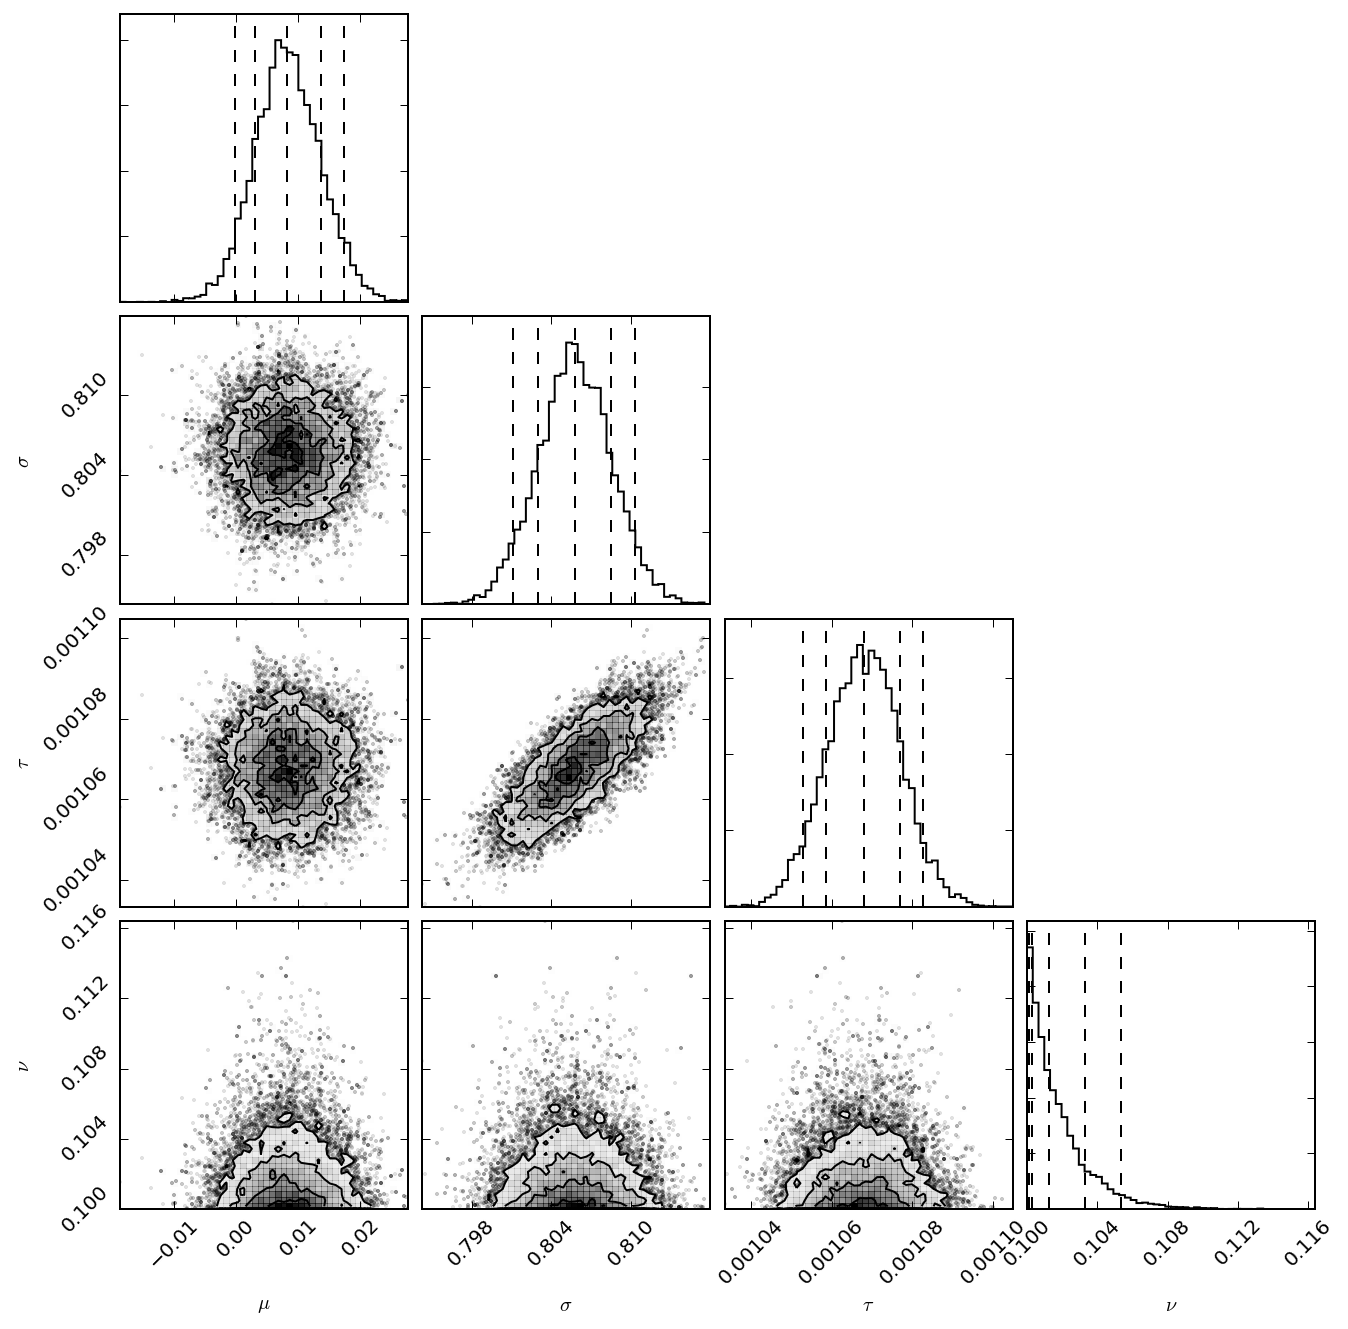

In [43]:
pars = []
for p in runner.burnedin_chain.reshape((-1, logpost.nparams)):
    pars.append(logpost.deparameterise(p))
pars = np.array(pars)
triangle.corner(pars, quantiles=[0.05, 0.16, 0.5, 0.84, 0.95], labels=[r'$\mu$', r'$\sigma$', r'$\tau$', r'$\nu$'])
None

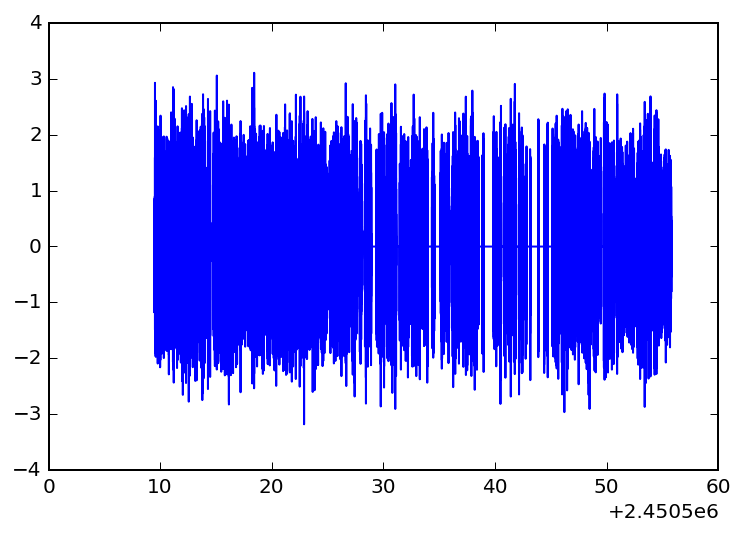

In [44]:
resid = 0
N = 1000
for p in permutation(runner.burnedin_chain.reshape((-1, logpost.nparams)))[:N]:
    y, yv = logpost.predict(p)
    resid += logpost.y - y
resid /= N
plot(logpost.t, resid)

Not quite sure what's going on here at high frequency---it *should* be solved by the white-noise fitting (which imposes a flat floor on the PSD), but the fits really would like there to be very little white noise, so the high-frequency stuff is being enhanced by the AR(1) filter).  Nevertheless, very promising.

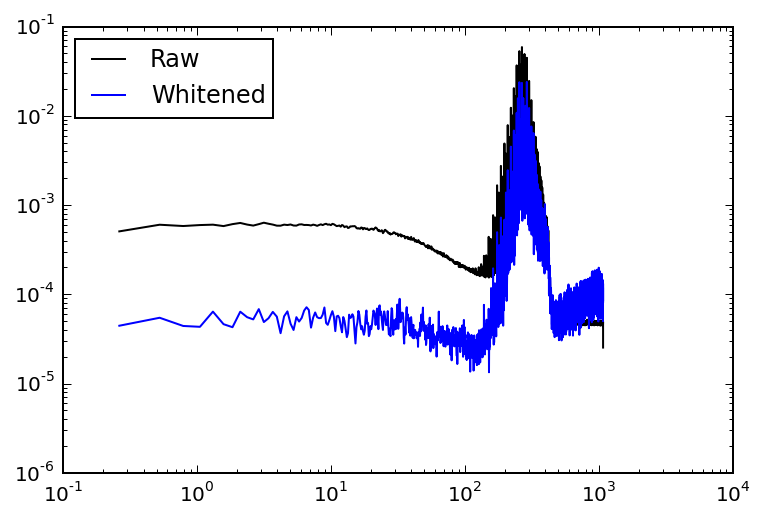

In [46]:
rfs, rpsd = ss.welch(resid, 1/dt, nperseg=8192)
loglog(fs, psd, '-k', label='Raw')
loglog(fs, rpsd, '-b', label='Whitened')
legend(loc='upper left')

Also, I notice that there are gaps in the above data, so I really shouldn't be using welch to produce the periodigram.  Oh well.  Still, it looks like a reasonable whitening procedure.

In [49]:
with h5py.File('gran5whitened.hdf5', 'w') as out:
    out.create_dataset('time', compression='gzip', data=logpost.t)
    out.create_dataset('samples', compression='gzip', data=logpost.y)
    out.create_dataset('whitened_samples', compression='gzip', data=resid)
    out['whitened_samples'].attrs['description'] = 'mean residual from AR(1) model'

    out.create_dataset('posterior_samples', compression='gzip', data=pars)
    out['posterior_samples'].attrs['param_names'] = ['mu', 'sigma', 'tau', 'nu']